In [7]:
import pandas as pd
import matplotlib.pyplot as plt

from pandas import DataFrame as df
import numpy as np
import csv
from itertools import combinations
from sklearn.model_selection import train_test_split
import math
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from scipy import stats
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
import pickle

from sklearn.metrics import pairwise_distances
from sklearn import preprocessing

import helper_functions as hf
import importlib
importlib.reload(hf)

<module 'helper_functions' from 'C:\\Users\\ctata\\Documents\\Lab\\quality_vectors\\helper_functions.py'>

In [9]:
otu_train, otu_test, qual_vecs_500, map_train, map_test = hf.getDataFreshwater(qual_vec_type = "500")

(18567, 5817)
(11133, 500)
OTU DROP SHAPE: (11132, 5790)
11132
Safe to continue
Mapping has shape: (27751, 75)
After selecting for biome, mapping has shape (5940, 75)
After selecting just the samples present in the otu table: (5790, 75)
After rearranging, we have 5790 matching samples
Safe to continue
We will be working with 4490 samples that have temperature information
Safe to continue


In [10]:
#Sample must have more than 5000 reads
otu_train_filt = otu_train.loc[otu_train.sum(axis=1) > 5000, :]
otu_test_filt = otu_test.loc[otu_test.sum(axis=1) > 5000, :]

map_train_filt = map_train.loc[otu_train_filt.index.values]
map_test_filt = map_test.loc[otu_test_filt.index.values]

In [11]:
def log_normalize(otu):
    return(np.log(otu + 1))

otu_norm = log_normalize(otu_train_filt)
otu_norm_test = log_normalize(otu_test_filt)


print(otu_norm.shape)
print(otu_norm_test.shape)
print(map_train_filt.shape)
print(map_test_filt.shape)

(2398, 11132)
(1441, 11132)
(2398, 75)
(1441, 75)


ML filtered features

In [12]:
f = open("feature_selection/ml_filtered_features.obj", "rb")
ml_features = pickle.load(f)
f.close()

otu_ml_raw = otu_train_filt[list(ml_features)]
otu_ml_test_raw = otu_test_filt[list(ml_features)]

otu_ml = otu_norm[list(ml_features)]
otu_ml_test = otu_norm_test[list(ml_features)]

Bio filtered features

In [6]:
#Filter for useful taxa
file = open('feature_selection/taxa_lowphy_highcos.obj', 'rb')
taxa_lowphy_highcos = pickle.load(file)
file.close()

otu_bio = otu_norm[list(taxa_lowphy_highcos)]
otu_bio_test = otu_norm_test[list(taxa_lowphy_highcos)]

Randomly selected features

In [8]:
def randomfilter(otu, otu_test, numFeatures):
    np.random.seed(15)
    features = np.random.choice(otu.columns.values, numFeatures)
    otu_rand = otu[list(features)]
    otu_rand_test = otu_test[list(features)]
    
    return(otu_rand, otu_rand_test)

otu_rand, otu_rand_test = randomfilter(otu_norm, otu_norm_test, otu_bio.shape[1])


In [17]:
print(otu_rand.shape)
print(otu_rand_test.shape)

NameError: name 'otu_rand' is not defined

22.9
Slope: 0.6053458615624933
R value: 0.3231632998849532
Linear Error3.439756228345162   MSE: 17.401308725830194
22.9
Slope: 0.47768458530940594
R value: 0.37054898586429114
Linear Error3.507392287680029   MSE: 18.72710208875126


(3.507392287680029, 18.72710208875126)

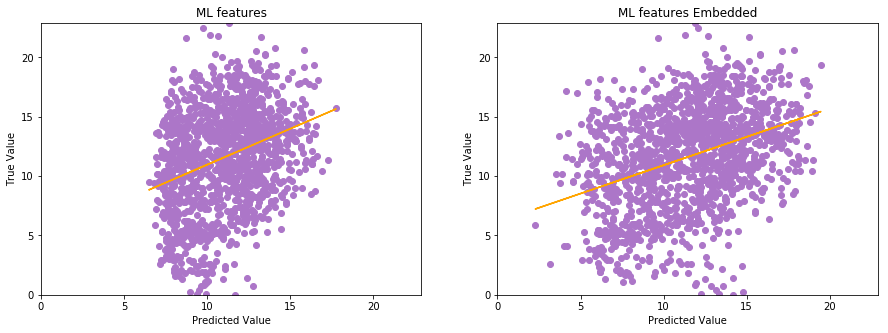

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "svm", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_ml, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_ml_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "svm", title = "ML features Embedded")

In [34]:
def embed_count_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = log_normalize(otu)
    frequencies = occurrence.sum(axis = 0) + 1
    inverse_freq_mat = occurrence.div(frequencies, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

In [43]:
def embed_occurrence(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = otu.astype(bool)
    df = pd.DataFrame(np.dot(occurrence, qual_vecs_use), index = otu.index.values)
    return(df)

In [44]:
def embed_frequency(otu, qual_vecs):
    qual_vecs_use = qual_vecs.loc[list(otu.columns.values)]
    occurrence = otu.astype(bool)
    frequencies = occurrence.sum(axis = 0)
    inverse_freq_mat = occurrence.div(frequencies, axis = 1)
    df = pd.DataFrame(np.dot(inverse_freq_mat, qual_vecs_use), index = otu.index.values)
    return(df)

(2398, 1573)

In [31]:
embed_idf_train = embed_count_frequency(otu_ml_raw, qual_vecs_500)
embed_idf_test = embed_count_frequency(otu_ml_test_raw, qual_vecs_500)

22.9
Slope: 0.6682962385696718
R value: 0.2497392303118742
Linear Error3.4720957052788486   MSE: 19.061721984577478
22.9
Slope: 0.33915170527204286
R value: 0.18209179826122926
Linear Error3.6484895938601696   MSE: 20.184858707366296


(3.6484895938601696, 20.184858707366296)

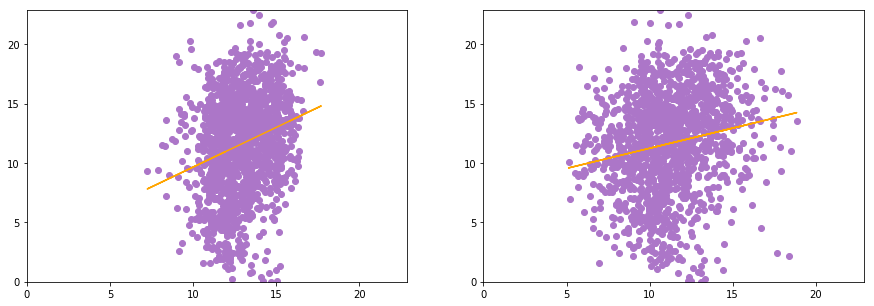

In [33]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(embed_idf_train), map_train_filt.temperature_deg_c, 
             preprocessing.scale(embed_idf_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: 0.6682962385696718
R value: 0.2497392303118742
Linear Error3.4720957052788486   MSE: 19.061721984577478
22.9
Slope: 0.32814076354091704
R value: 0.19952190047250667
Linear Error3.6671199489428257   MSE: 20.59374152743087


(3.6671199489428257, 20.59374152743087)

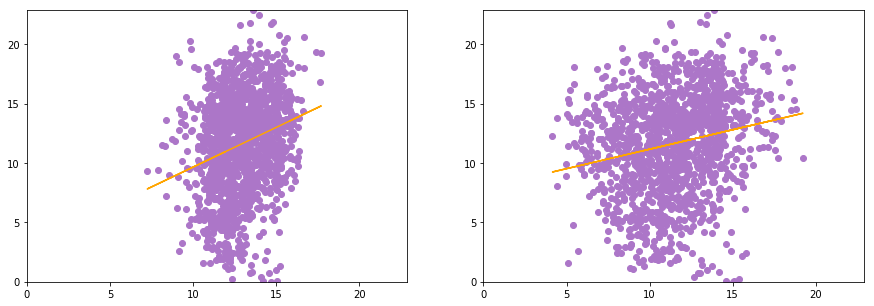

In [45]:

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(embed_occurrence(otu_ml_raw, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(embed_occurrence(otu_ml_test_raw, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: 0.6682962385696718
R value: 0.2497392303118742
Linear Error3.4720957052788486   MSE: 19.061721984577478


c:\users\ctata\miniconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype object were all converted to float64 by the scale function.
  import sys


TypeError: Could not operate array([ 68, 651, 157, ...,   7,  56, 655], dtype=int64) with block values division by zero

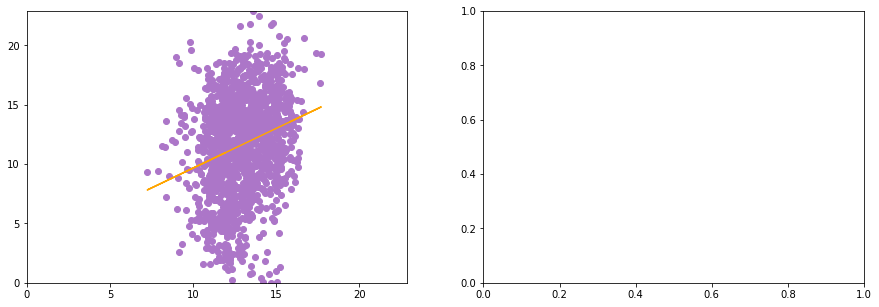

In [46]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(embed_frequency(otu_ml_raw, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(embed_frequency(otu_ml_test_raw, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: 0.6734187020819634
R value: 0.2303133522534544
Linear Error3.4020717214589595   MSE: 17.504447861838255
22.9
Slope: 0.4367654440904584
R value: 0.27187110030161493
Linear Error3.562166480757668   MSE: 19.21836146001077


(3.562166480757668, 19.21836146001077)

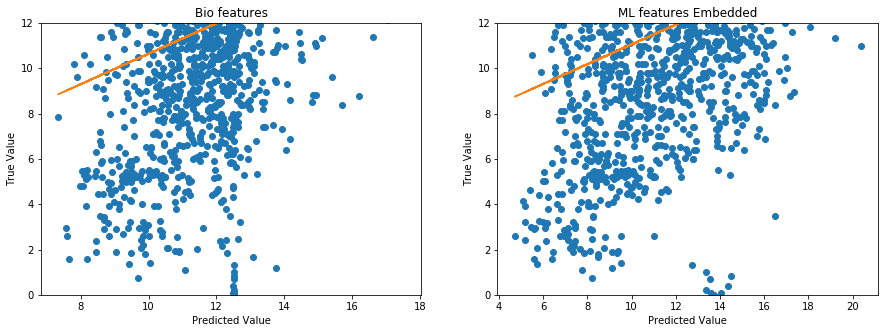

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_bio), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_bio_test), map_test_filt.temperature_deg_c, model = "svm", title = "Bio features")

plt.subplot(1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_bio, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_bio_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "svm", title = "Bio features Embedded")

22.9
Slope: 1.0069151742179259
R value: 0.33295419696804307
Linear Error3.2835965303476273   MSE: 16.277240313616566
22.9
Slope: 0.34263577761314445
R value: 0.21782849939960486
Linear Error3.649994069183176   MSE: 20.941421921629395


(3.649994069183176, 20.941421921629395)

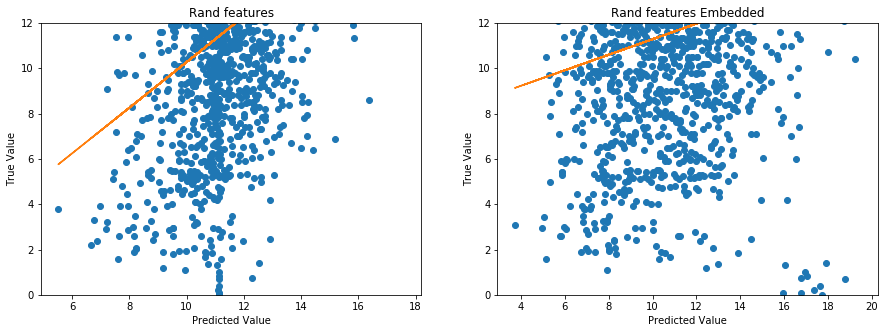

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_rand), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_rand_test), map_test_filt.temperature_deg_c, model = "svm", title = "Rand features")

plt.subplot(1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_rand, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_rand_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "svm", title = "Rand features Embedded")

Random Forest Models

In [11]:
otu_ml.shape

(2398, 1573)

22.9
Slope: 0.672816139815943
R value: 0.24829051355135515
Linear Error3.4700303860180393   MSE: 19.0392229998574
22.9
Slope: 0.49105908588256425
R value: 0.257123703251457
Linear Error3.4799741089427534   MSE: 18.306019075159984


(3.4799741089427534, 18.306019075159984)

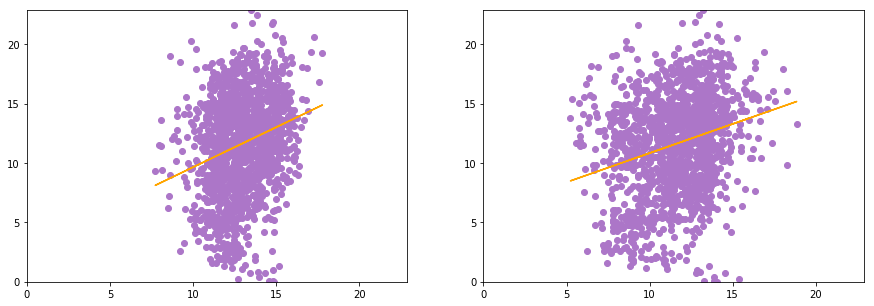

In [16]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_ml, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_ml_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: 0.6559144392536141
R value: 0.2465662061766844
Linear Error3.489863475986907   MSE: 19.13721231002958
22.9
Slope: 0.49105908588256425
R value: 0.257123703251457
Linear Error3.4799741089427534   MSE: 18.306019075159984


(3.4799741089427534, 18.306019075159984)

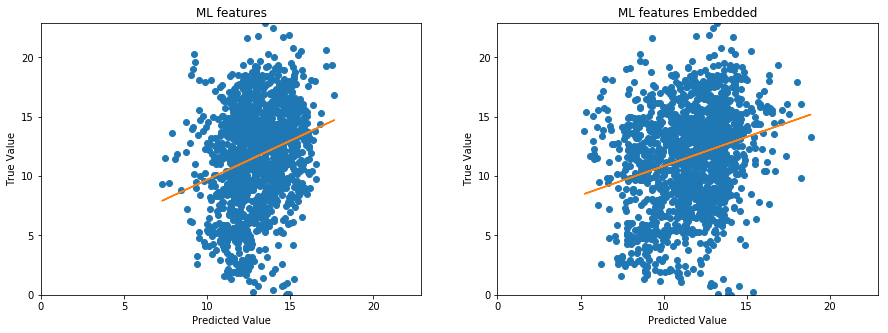

In [10]:
#Log normalized
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_ml), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_ml_test), map_test_filt.temperature_deg_c, model = "rf", title = "ML features")

plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_ml, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_ml_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: 0.501322256250158
R value: 0.203993777165684
Linear Error3.4973725851831494   MSE: 18.614326647839224


(3.4973725851831494, 18.614326647839224)

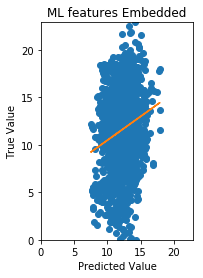

In [13]:
plt.subplot( 1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_ml_raw, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_ml_test_raw, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "ML features Embedded")

22.9
Slope: -0.14891333297408402
R value: -0.05260151683496125
Linear Error3.8175223186690874   MSE: 23.695953554080642
22.9
Slope: 0.33357593934581015
R value: 0.10470826771018368
Linear Error3.64723786540623   MSE: 20.728934571000227


(3.64723786540623, 20.728934571000227)

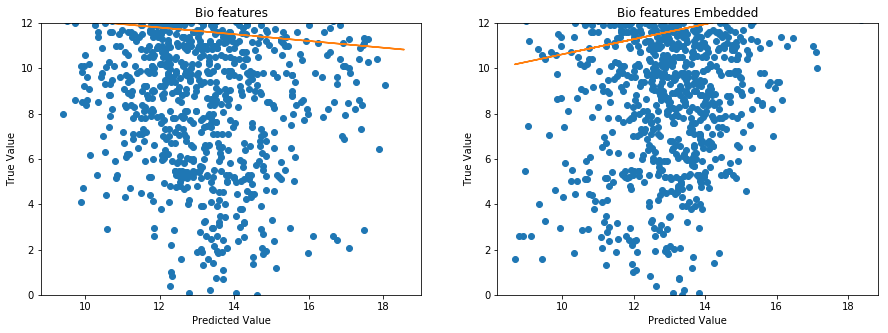

In [32]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_bio), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_bio_test), map_test_filt.temperature_deg_c, model = "rf", title = "Bio features")

plt.subplot(1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_bio, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_bio_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "Bio features Embedded")

22.9
Slope: 0.5056551570810326
R value: 0.19639295931658649
Linear Error5.364139065104232   MSE: 44.03777435816115
22.9
Slope: 0.29159409624533605
R value: 0.08246795589256974
Linear Error3.5901091033879493   MSE: 20.491098596574325


(3.5901091033879493, 20.491098596574325)

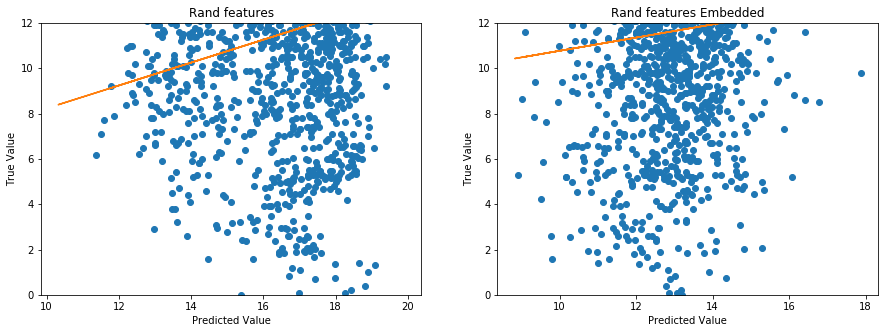

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
hf.testModel(preprocessing.scale(otu_rand), map_train_filt.temperature_deg_c, 
             preprocessing.scale(otu_rand_test), map_test_filt.temperature_deg_c, model = "rf", title = "Rand features")

plt.subplot(1, 2, 2)
hf.testModel(preprocessing.scale(hf.embed(otu_rand, qual_vecs_500)), map_train_filt.temperature_deg_c, 
             preprocessing.scale(hf.embed(otu_rand_test, qual_vecs_500)), map_test_filt.temperature_deg_c, model = "rf", title = "Rand features Embedded")